# First things first

Let's import all the fun stuff that lets us do the really fun stuff.

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
 

rcParams['figure.figsize'] = 16,9
pd.options.plotting.backend = "matplotlib"
sns.set(style="darkgrid")

figs = {}

# Prepping the data

We're going to load our words from the word lists that we copied from the source code. There are two lists, one which seems to be a list of played words and ones that have yet to be released.

In [2]:
playable_words = pd.read_json("../data/raw/played_words.json")
other_words = pd.read_json("../data/raw/unplayed_words.json")

playable_words[1] = True
other_words[1] = False

words = pd.concat([playable_words, other_words])
words.columns = ["name", "playable"]
words.reset_index()

words.describe()

,name,playable
count,12972,12972
unique,12972,2
top,cigar,False
freq,1,10657


# First Heuristic: Letter Rank

It's pretty simple: we're going to find out how often each letter is used in the entire wordle word list and rank them using a barplot. Once that is done, we'll check to see if there are any words spelled using the top 5 letters in the word list. 

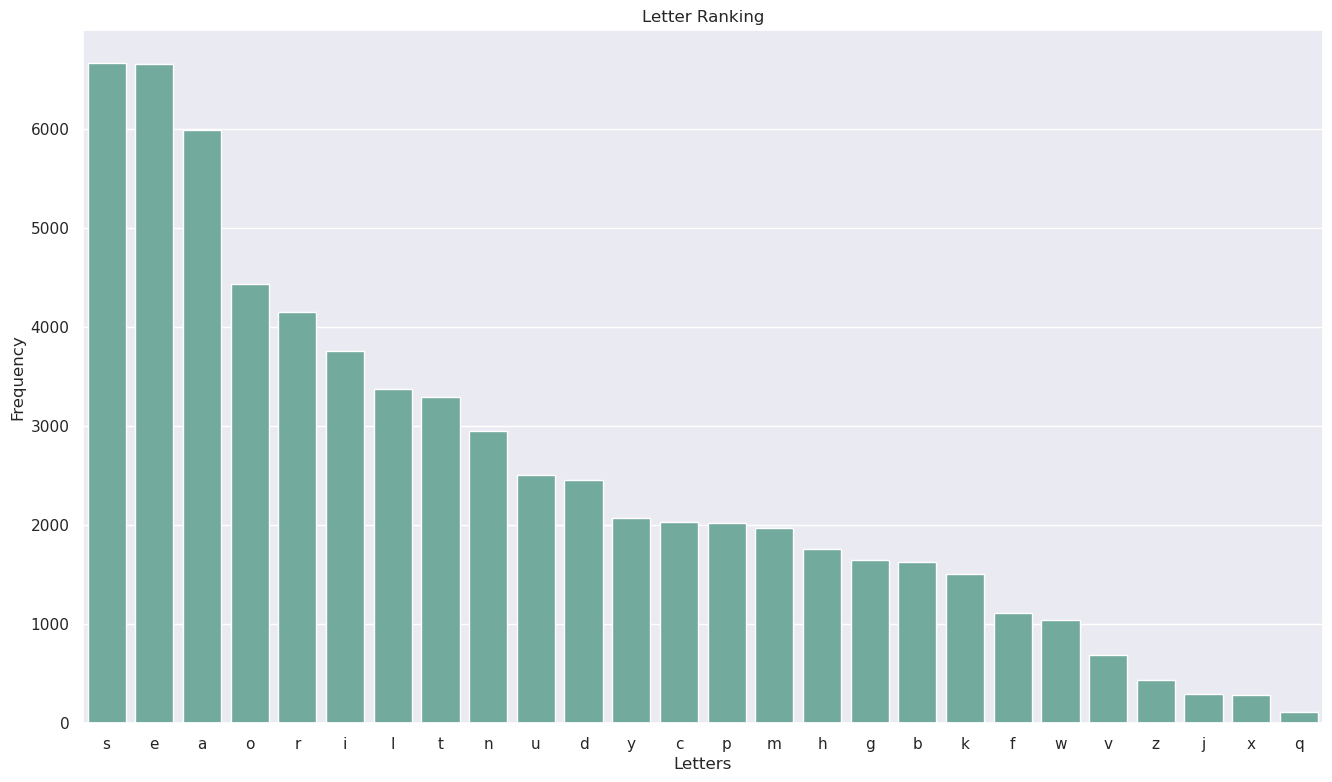

In [3]:
from itertools import chain

game1 = {}

letters = pd.Series(chain.from_iterable(words["name"]))
letter_counts = letters.value_counts()

ax = sns.barplot(
    x=letter_counts.index,
    y=letter_counts,
    color='#69b3a2'
)
ax.set_xlabel("Letters")
ax.set_ylabel("Frequency")
ax.set_title("Letter Ranking")
figs["letter_ranking.png"] = ax.figure

From the above, we can see that the top 5 letters are: s, e, a, o and r. Given that information, let's try and find out if there are any words spelled using all five letters.

In [4]:
def contains_all(letters):
    return lambda word:  set(letters) <= set(word)

all_top5_letters = words["name"].apply(contains_all("seaor"))
words[all_top5_letters]

,name,playable
1252,arose,True
112,aeros,False
8530,soare,False


The result is the following three words:
1. arose
2. aeros
3. soare

## First turn


In [5]:
def contains_any(letters):
    return lambda word: len(set(letters) & set(word)) > 0

any_top5_letter = words["name"].apply(contains_any("seaor"))
words_turn1 = words[any_top5_letter]
words_turn1.describe()

,name,playable
count,12395,12395
unique,12395,2
top,cigar,False
freq,1,10263


So what does that mean for us? Well, let's look at the worst possible scenario: that we get no yellow or green tiles. In this case, we've still managed to do away with a great deal of the problem space, out of a total 12,972 words we've eliminated 12,395. Using only 1/6th of the time given to us, we've eliminated 95% of the problem space. Let's filter for any possible words using the next 5 most common letters.

## Second Turn

The next five most frequent letters according to our chart are i, l, t, n and u. Same as above, we'll check the remaining words in the list and see if all five letters can be used to play a word.

In [6]:
remaining_words = words[~any_top5_letter]
all_next5_letters = remaining_words["name"].apply(contains_all("intlu"))
remaining_words[all_next5_letters]

,name,playable
444,unlit,True
986,until,True


So we have two words that use the letters ranking 6 through 10. Again, our worst case scenario is that none of these letters our in the secret word. How many possibilities have we eliminated?

In [7]:
any_next5_letters = remaining_words["name"].apply(contains_any("until"))
words_turn2 = remaining_words[any_next5_letters]
words_turn2.describe()

,name,playable
count,574,574
unique,574,2
top,humph,False
freq,1,392


Two turns done, and we have eliminated 12,969 (12,395 + 574) words. By turn 3, this means that we have the following possiblities left. Even if we ignore the clues dropped by the game, in three more turns, we'll have the answer (assuming we actually know these words).

In [8]:
remaining_words = remaining_words[~any_next5_letters]
remaining_words

,name,playable
2132,pygmy,True
3836,gyppy,False
4261,hyphy,False


,Words
Turn 1,12395
Turn 2,574
Remaining,3


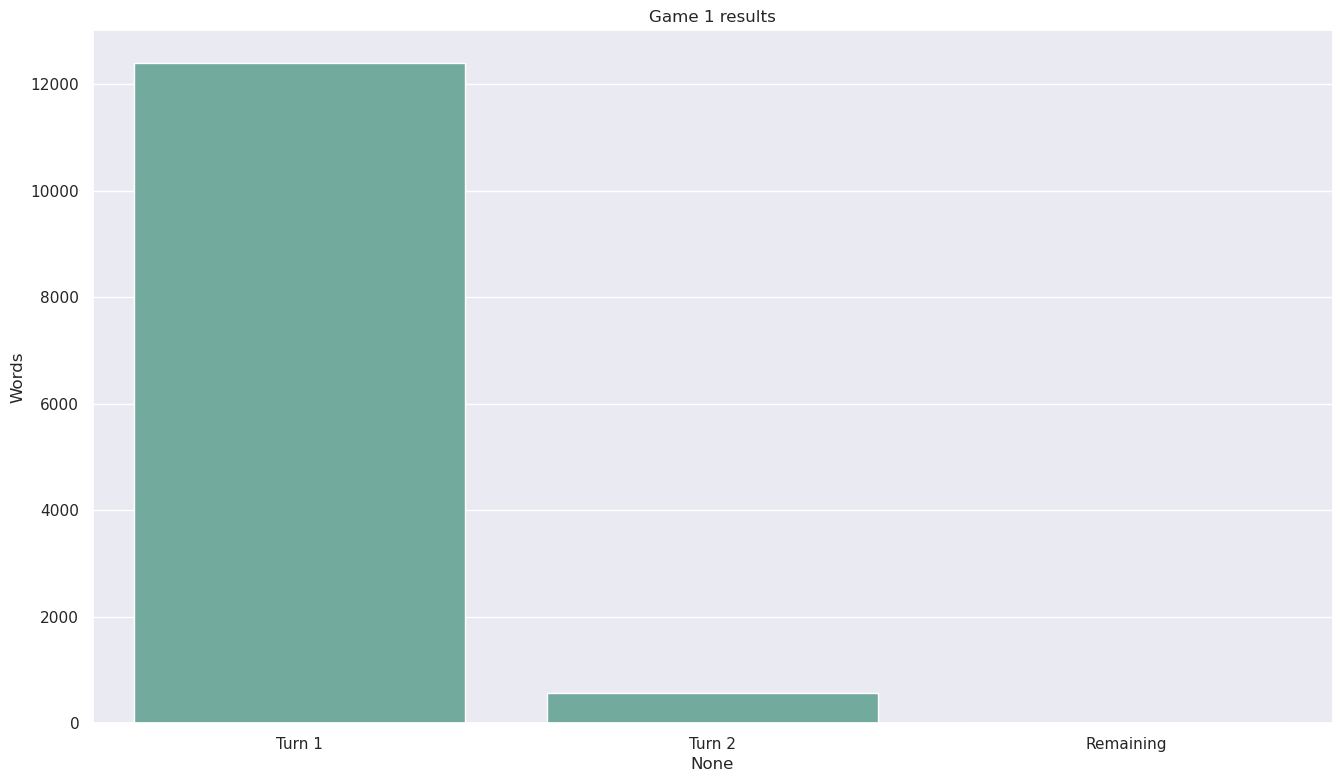

In [9]:
first_game = pd.DataFrame.from_dict({
    "Turn 1": words_turn1["name"].count(),
    "Turn 2": words_turn2["name"].count(),
    "Remaining": remaining_words["name"].count()
}, orient="index", columns=["Words"])

ax = sns.barplot(
    x=first_game.index,
    y=first_game.Words,
    color='#69b3a2'
)
#ax.set_xlabel("Letters")
ax.set_ylabel("Words")
ax.set_title("Game 1 results")
figs["first_game_result.png"] = ax.figure
first_game

# Second Heuristic: Et tu Brute-force-us

Our first heuristic used the most common letters to find words that could match against. The thing is, a (good) heuristic gives us an answer that is good enough. So did our heuristic give us the word that eliminates the most 

In [10]:
def count_matches(words):
    return lambda word: words.apply(
        contains_any(word)
    ).value_counts()[True] # remove the word itself from number of matches

words["starter_score"] = words["name"].apply(count_matches(words["name"]))

words[words["starter_score"] == words["starter_score"].max()]

,name,playable,starter_score
8810,stoae,False,12417
9373,toeas,False,12417


As it turns out, there are two words in the word list that just barely outperform our starter words consisting of the top 5 letter (and I have no idea what they mean):
1. Stoae
2. Toeas

## Turn 1
Since we already know how many words we rule out by playing either of the words above, we can go directly to figuring out what our options are for turn 2 in case we don't match any letters at all.

In [11]:
any_top5_letter = words["name"].apply(contains_any("stoae"))
remaining_words = words[~any_top5_letter].copy()
remaining_words["starter_score"] = remaining_words["name"].apply(count_matches(remaining_words["name"]))
remaining_words[remaining_words["starter_score"] == remaining_words["starter_score"].max()]

,name,playable,starter_score
195,unify,True,554
754,juicy,True,554
5379,lupin,False,554


We get three words that match the most remaining words. In fact, they match all the remaining words except one.

## Turn 2
We can play one of the three words above to find out what the last word is: grrrl.

I was not expecting that.

In [12]:
any_next5_letters = remaining_words["name"].apply(contains_any("unify"))
remaining_words = remaining_words[~any_next5_letters]
remaining_words

,name,playable,starter_score
3754,grrrl,False,363


It would seem that the second method outperforms the first. We're guaranteed to figure the wordle out even if the first two turns don't reveal any green or yellow tiles.

,Words
Turn 1,12417
Turn 2,554
Remaining,1


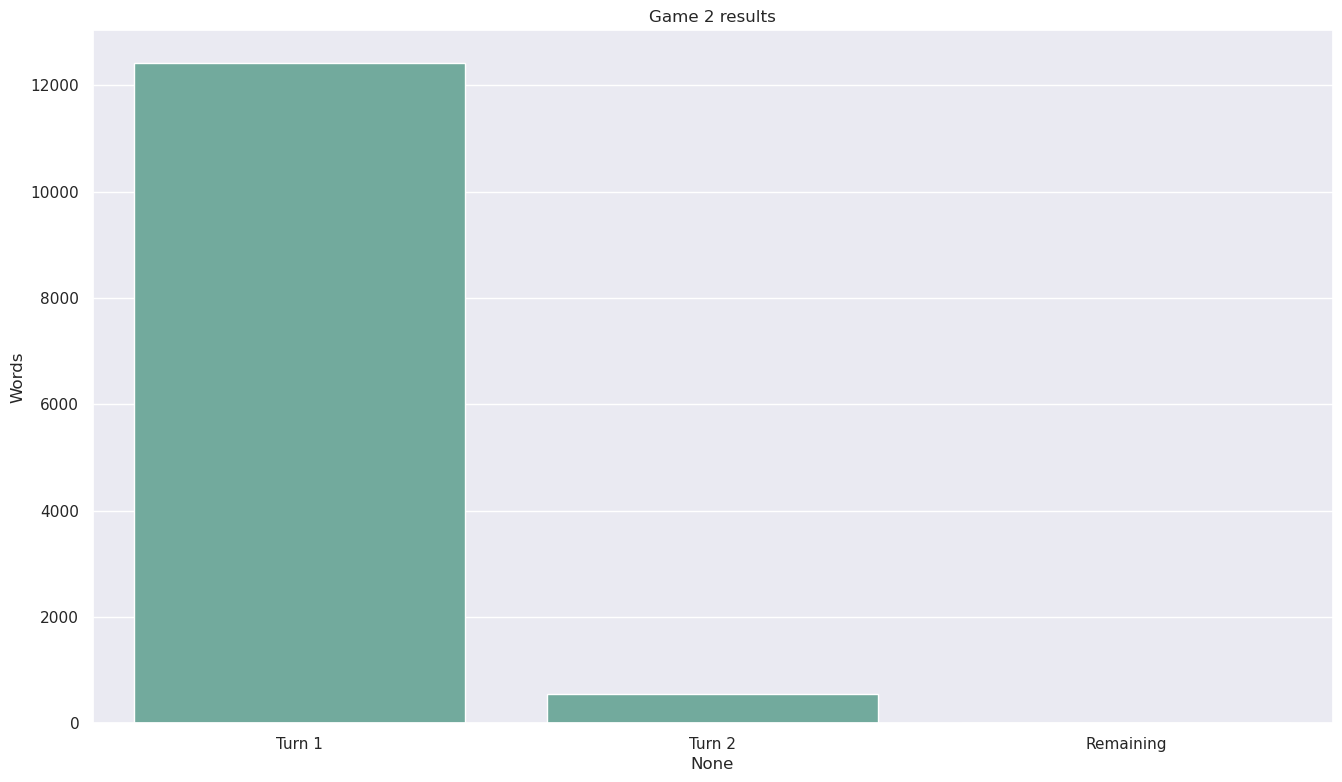

In [13]:
second_game = pd.DataFrame.from_dict({
    "Turn 1": 12417,
    "Turn 2": 554,
    "Remaining": 1
}, orient="index", columns=["Words"])

ax = sns.barplot(
    x=second_game.index,
    y=second_game.Words,
    color='#69b3a2'
)
#ax.set_xlabel("Letters")
ax.set_ylabel("Words")
ax.set_title("Game 2 results")
figs["second_game_result.png"] = ax.figure
second_game

# When you assume, you make ...
Having done all the analysis above, can we say that the second heuristic is better than the first?
1. Is the worst case scenario really the worst case scenario? How can we find out?
2. How do does discovering a yellow or green tile change the likelihood of other letters appearing in the wordle?
3. How do you even compare two heuristics or techniques?
4. Is there a great starter word?
5. We're assuming that the player knows ALL the words in the wordle word list.

# Final Thoughts (Work in progress)


In [14]:
matches = words[words['name'].apply(contains_all('sta'))]
matches = matches[~matches['name'].apply(contains_any('oe'))]



# Don't mind me
Just saving the plots

In [16]:
for name, figure in figs.items():
    figure.savefig("../results/figures/" + name)